# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [106]:
data = pd.read_csv("Examen.csv")
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [107]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Crear una serie de fechas a partir de enero de 2008, asignándolas a la columna 'Mes'
data['Mes'] = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')

# Mostrar los primeros datos para verificar
print(data.head())

# Guardar el nuevo dataset con la columna de "Mes"
data.to_csv('Examen2.csv', index=False)


         Mes    producto1    producto2
0 2008-01-01  4000.000000  3000.000000
1 2008-02-01  3997.400893  3010.686220
2 2008-03-01  3978.605317  3022.018584
3 2008-04-01  3986.454125  3033.920990
4 2008-05-01  3979.695678  3038.402098


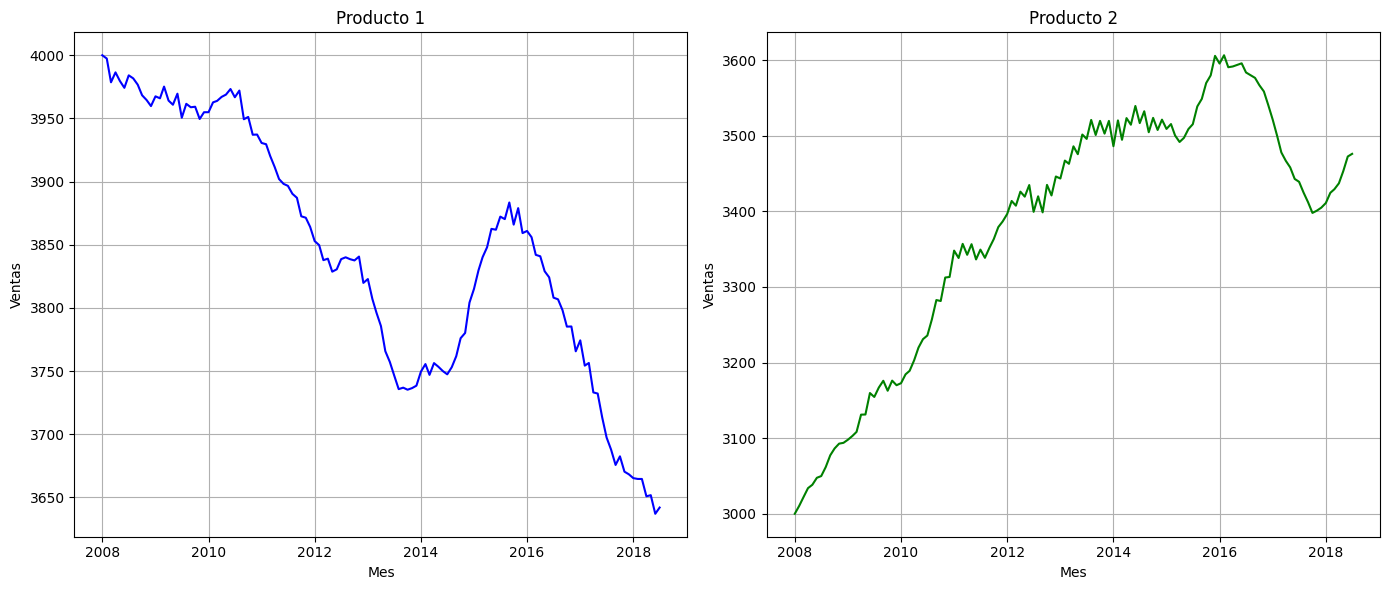

In [108]:
# Convertir la columna 'Mes' a tipo datetime si no lo está
data['Mes'] = pd.to_datetime(data['Mes'])

# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data['Mes'], data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data['Mes'], data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [109]:
product_1_df = data[['producto1']]
product_1_df.index = data['Mes']
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data['Mes']



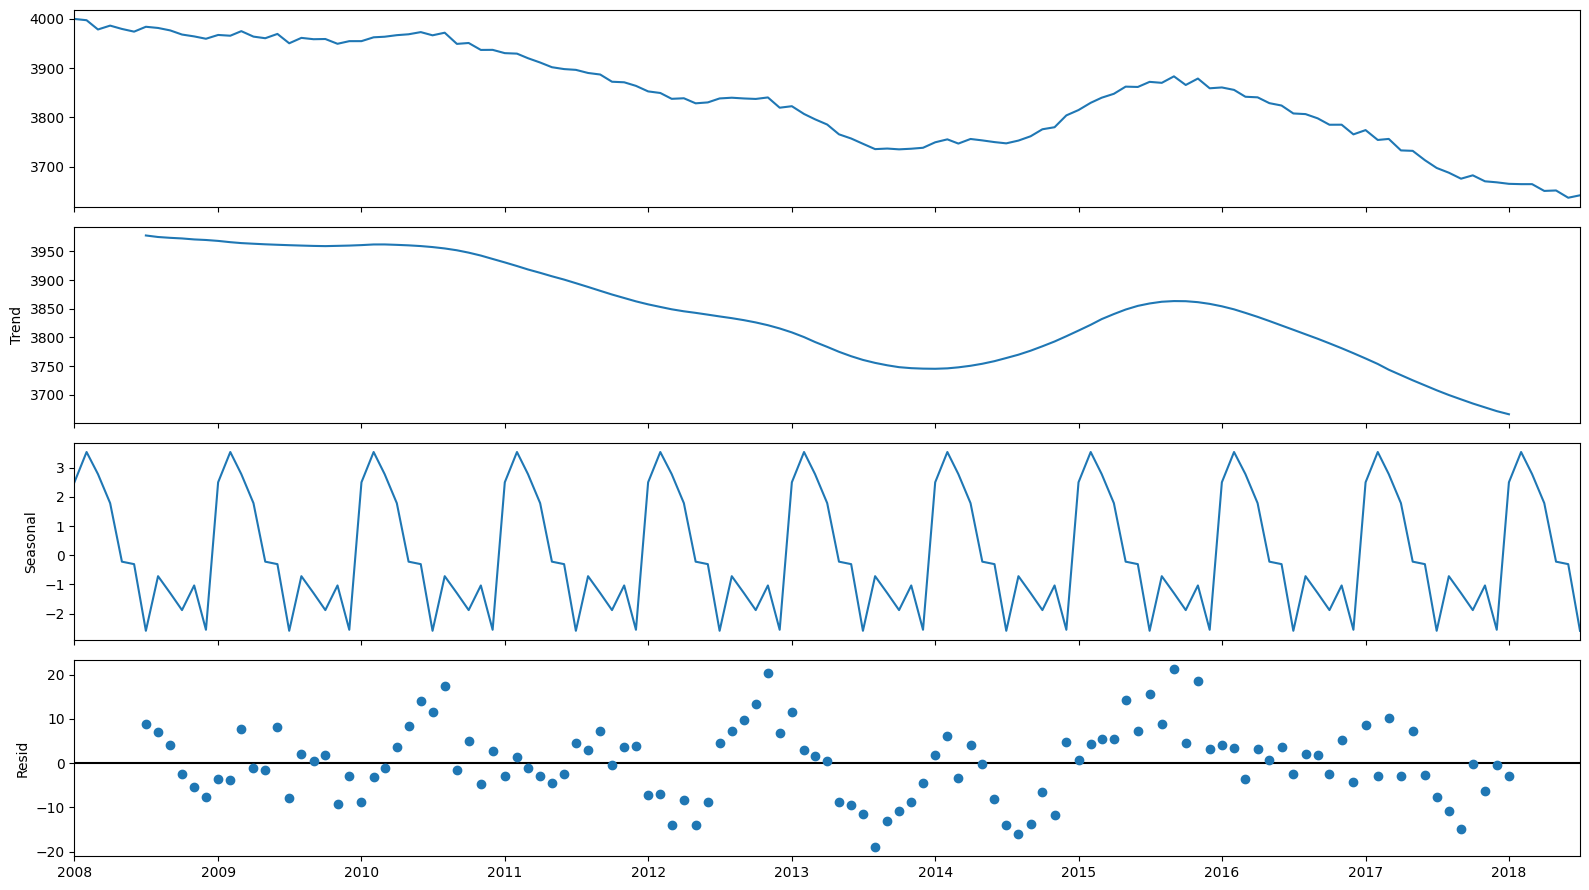

In [110]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

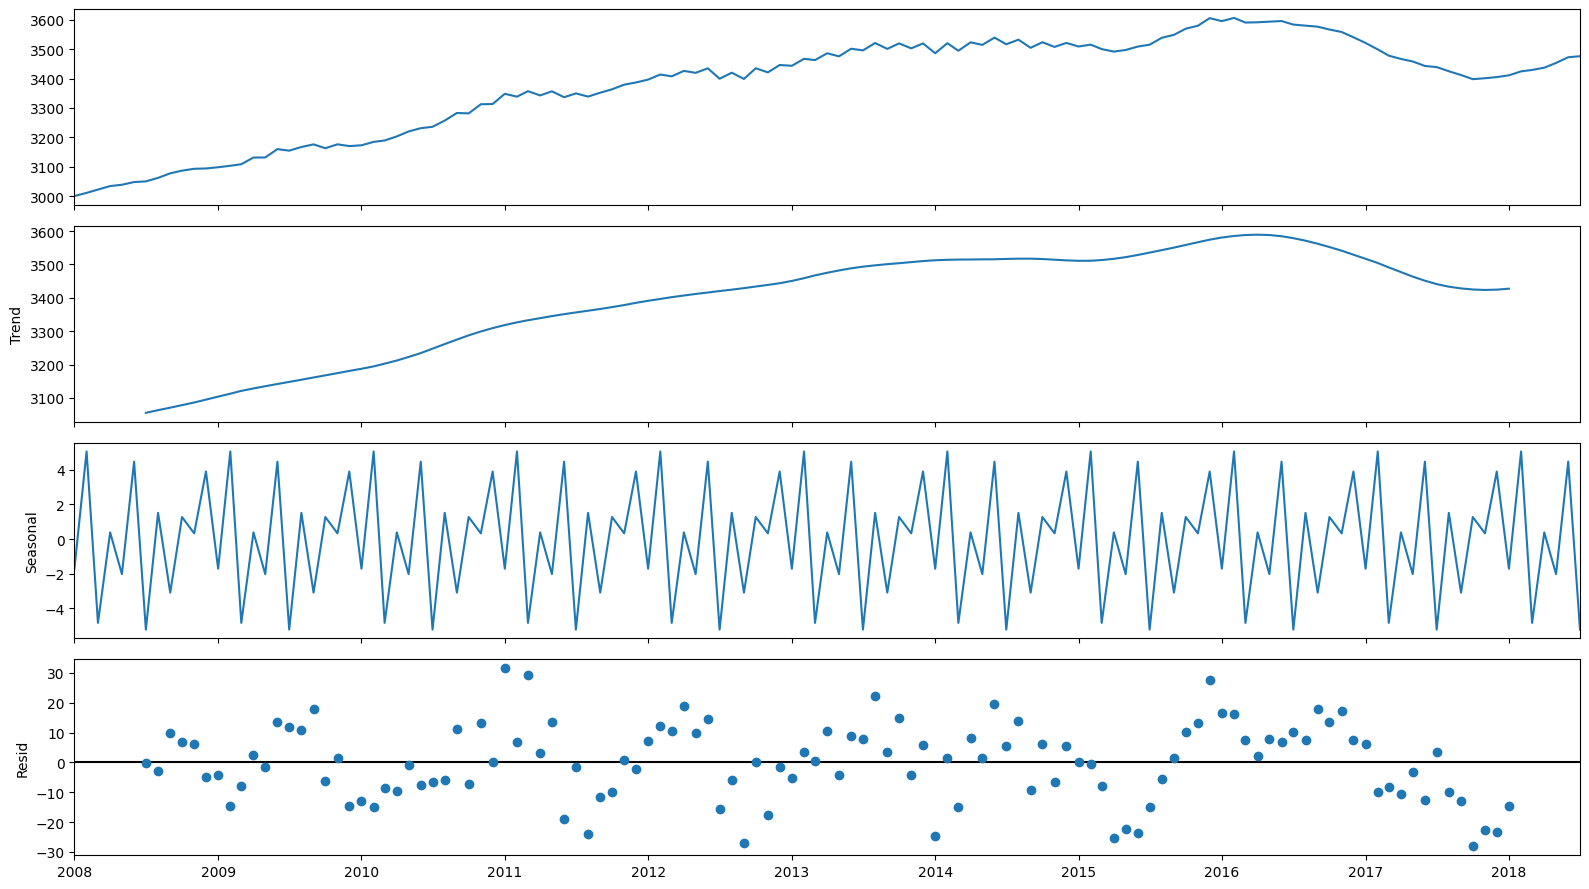

In [111]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [112]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [113]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(
    model_class,
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    init_args=None,
    fit_args=None
):
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    # Ensure init_args and fit_args are dictionaries
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate the model with provided init_args
        model = model_class(y_train, **init_args)

        # Fit the model with fit_args if provided
        model_fit = model.fit(**fit_args)

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])  # Storing the first forecast value

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [114]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full plot with highlighted forecast section
    ax[0].plot(data.index, data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue', marker='o')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange', marker='o')

    # Adding subtle lines to indicate the delta between actual and forecast
    for i in range(len(forecasts)):
        ax[1].plot([forecast_indices[i], forecast_indices[i]], [data[train_size + i], forecasts[i]], color='red', linestyle='--', linewidth=2)

    ax[1].set_title('Zoomed-In Forecast Section with Delta Lines')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [115]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args={
        'window': 3
	}
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


Promedio móvil RMSE: 9.680204135597737


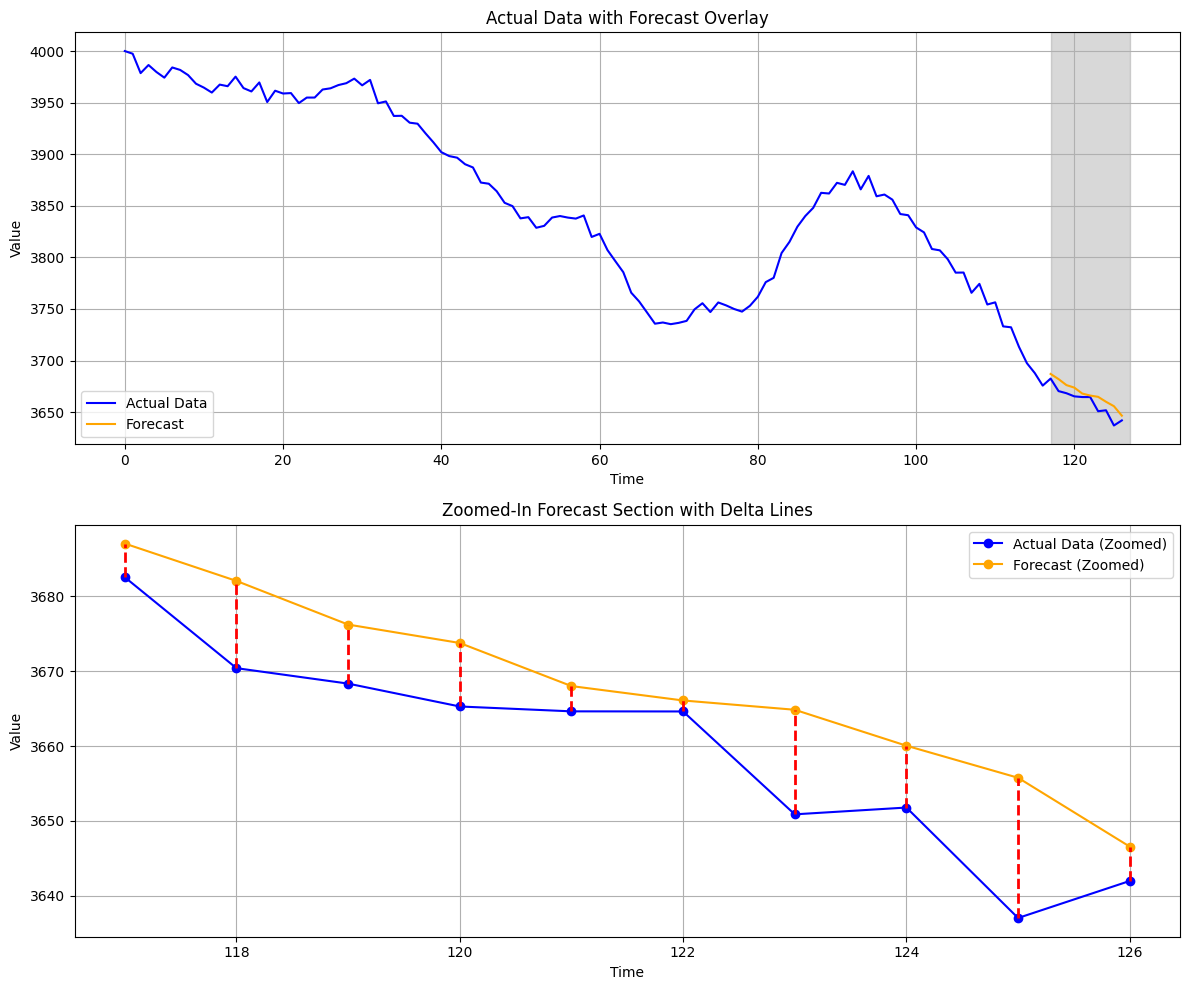

In [116]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [117]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

# Crear el dataset con 'Mes' y 'producto1'
data_producto1 = data[['Mes', 'producto1']].set_index('Mes')

# Crear el dataset con 'Mes' y 'producto2'
data_producto2 = data[['Mes', 'producto2']].set_index('Mes')

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('MS')  # Mes

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('MS')  # Mes

# Mostrar los primeros datos para verificar
print(data_producto1.head())
print(data_producto2.head())


              producto1
Mes                    
2008-01-01  4000.000000
2008-02-01  3997.400893
2008-03-01  3978.605317
2008-04-01  3986.454125
2008-05-01  3979.695678
              producto2
Mes                    
2008-01-01  3000.000000
2008-02-01  3010.686220
2008-03-01  3022.018584
2008-04-01  3033.920990
2008-05-01  3038.402098


In [118]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):
    """Function we want to maximize (Black box)"""

    train_data = data_producto1[:len(data_producto1)-10]
    test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]

    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]

    # Asegúrate de que el índice tenga una frecuencia definida
    if train_data.index.freq is None:
        train_data = train_data.asfreq('D')  # Ajusta 'D' a la frecuencia que corresponda

    model = ETSModel(
        endog=train_data[train_data.columns[0]],
        error=error1[round(error)],
        trend=trend1[round(trend)],
        seasonal=seasonal1[round(seasonal)],
        seasonal_periods=12  # Ajusta según sea necesario
    )

    params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

    if trend1[round(trend)] is None:
        params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] is None:
        params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast = model_result.forecast(10)
    rmse = np.sqrt(mean_squared_error(test_data, point_forecast))

    print(f"target es: {rmse}, Error test: {error1[round(error)]}, Trend test: {trend1[round(trend)]}, Seasonal test: {seasonal1[round(seasonal)]}, Alpha model: {alpha}, Beta model: {beta}, Gamma model: {gamma}")

    return -rmse


In [119]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [120]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [121]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19961D+00    |proj g|=  2.10712D-02

At iterate    1    f=  3.64284D+00    |proj g|=  6.62013D-03

At iterate    2    f=  3.63919D+00    |proj g|=  6.74938D-03

At iterate    3    f=  3.63867D+00    |proj g|=  6.87379D-03

At iterate    4    f=  3.62548D+00    |proj g|=  9.08562D-03

At iterate    5    f=  3.56936D+00    |proj g|=  9.51874D-03

At iterate    6    f=  3.55844D+00    |proj g|=  3.70086D-03

At iterate    7    f=  3.55177D+00    |proj g|=  7.14628D-03

At iterate    8    f=  3.54827D+00    |proj g|=  8.15303D-03

At iterate    9    f=  3.53878D+00    |proj g|=  6.03708D-03

At iterate   10 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00573D+00    |proj g|=  3.18213D+01

At iterate    1    f=  3.98060D+00    |proj g|=  1.63125D+00

At iterate    2    f=  3.98054D+00    |proj g|=  8.89969D-02

At iterate    3    f=  3.98054D+00    |proj g|=  1.05471D-02

At iterate    4    f=  3.98054D+00    |proj g|=  3.11666D-02

At iterate    5    f=  3.98054D+00    |proj g|=  1.00942D-01

At iterate    6    f=  3.98054D+00    |proj g|=  2.39208D-01

At iterate    7    f=  3.98053D+00    |proj g|=  4.46652D-01

At iterate    8    f=  3.98052D+00    |proj g|=  7.93131D-01

At iterate    9    f=  3.98049D+00    |proj g|=  1.34557D+00

At iterate   10    f=  3.98041D+00    |proj g|=  2.24612D+00

At iterate   11    f=  3.98021D+00    |proj g|=  3.70026D+00

At iterate   12    f=  3.97967D+00    |proj g|=  6.04762D+00

At iterate   13    f=  3.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99710D+00    |proj g|=  2.81427D+01

At iterate    1    f=  4.20347D+00    |proj g|=  1.84270D+01

At iterate    2    f=  4.19391D+00    |proj g|=  3.27799D+01

At iterate    3    f=  4.19035D+00    |proj g|=  1.61692D+01

At iterate    4    f=  4.18651D+00    |proj g|=  7.00566D+00

At iterate    5    f=  4.17860D+00    |proj g|=  9.92332D+00

At iterate    6    f=  4.16000D+00    |proj g|=  3.07626D+01

At iterate    7    f=  4.13752D+00    |proj g|=  3.77949D+01

At iterate    8    f=  4.11777D+00    |proj g|=  1.55041D+01

At iterate    9    f=  4.11325D+00    |proj g|=  4.95180D+00

At iterate   10    f=  4.11202D+00    |proj g|=  1.01693D+01

At iterate   11    f=  4.10860D+00    |proj g|=  1.82474D+01

At iterate   12    f=  4.10409D+00    |proj g|=  2.05203D+01

At iterate   13    f=  4.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27662D+00    |proj g|=  9.03531D+00

At iterate    1    f=  5.26810D+00    |proj g|=  8.58780D-01

At iterate    2    f=  5.26802D+00    |proj g|=  1.77049D-02

At iterate    3    f=  5.26802D+00    |proj g|=  1.76694D-02

At iterate    4    f=  5.26802D+00    |proj g|=  8.23127D-02

At iterate    5    f=  5.26802D+00    |proj g|=  1.81918D-01

At iterate    6    f=  5.26800D+00    |proj g|=  3.65206D-01

At iterate    7    f=  5.26797D+00    |proj g|=  6.49607D-01

At iterate    8    f=  5.26787D+00    |proj g|=  1.11640D+00

At iterate    9    f=  5.26763D+00    |proj g|=  1.86448D+00

At iterate   10    f=  5.26698D+00    |proj g|=  3.08824D+00

At iterate   11    f=  5.26531D+00    |proj g|=  5.06258D+00

At iterate   12    f=  5.26093D+00    |proj g|=  8.27740D+00

At iterate   13    f=  5.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63119D+00    |proj g|=  3.27857D+01

At iterate    1    f=  4.23575D+00    |proj g|=  1.16323D+01

At iterate    2    f=  4.23048D+00    |proj g|=  1.30229D+01

At iterate    3    f=  4.20582D+00    |proj g|=  3.16034D+00

At iterate    4    f=  4.20201D+00    |proj g|=  2.39281D+00

At iterate    5    f=  4.19723D+00    |proj g|=  2.57560D+00

At iterate    6    f=  4.19186D+00    |proj g|=  2.65125D+00

At iterate    7    f=  4.18971D+00    |proj g|=  3.53829D+00

At iterate    8    f=  4.18743D+00    |proj g|=  1.23729D+00

At iterate    9    f=  4.18614D+00    |proj g|=  1.64269D+00

At iterate   10    f=  4.18475D+00    |proj g|=  1.74993D+00

At iterate   11    f=  4.18428D+00    |proj g|=  1.75329D+00

At iterate   12    f=  4.18396D+00    |proj g|=  3.49486D-01

At iterate   13    f=  4.1

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63486D+00    |proj g|=  3.19868D+01

At iterate    1    f=  4.24677D+00    |proj g|=  2.20951D+01

At iterate    2    f=  4.22281D+00    |proj g|=  6.99450D+00

At iterate    3    f=  4.21456D+00    |proj g|=  6.42634D+00

At iterate    4    f=  4.20611D+00    |proj g|=  3.20096D+00

At iterate    5    f=  4.20111D+00    |proj g|=  3.15474D+00

At iterate    6    f=  4.19665D+00    |proj g|=  2.21804D+00

At iterate    7    f=  4.19090D+00    |proj g|=  2.44691D+00

At iterate    8    f=  4.18916D+00    |proj g|=  3.58788D+00

At iterate    9    f=  4.18754D+00    |proj g|=  1.62369D+00

At iterate   10    f=  4.18557D+00    |proj g|=  1.57953D+00

At iterate   11    f=  4.18434D+00    |proj g|=  1.32887D+00

At iterate   12    f=  4.18405D+00    |proj g|=  1.88152D+00

At iterate   13    f=  4.18362D+00    |proj g|=  3.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15139D+00    |proj g|=  5.37515D+00

At iterate    1    f=  4.10665D+00    |proj g|=  1.15737D+00

At iterate    2    f=  4.09909D+00    |proj g|=  1.11563D+00

At iterate    3    f=  4.08883D+00    |proj g|=  1.85216D+00

At iterate    4    f=  4.08684D+00    |proj g|=  1.58754D-01

At iterate    5    f=  4.08648D+00    |proj g|=  9.95586D-03

At iterate    6    f=  4.08648D+00    |proj g|=  1.06333D-02

At iterate    7    f=  4.08648D+00    |proj g|=  1.19364D-03

At iterate    8    f=  4.08648D+00    |proj g|=  1.19479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   18    f=  4.19130D+00    |proj g|=  5.76428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     18     48      2     0     0   5.764D-05   4.191D+00
  F =   4.1912954220741527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
target es: 35.53630634542986, Error test: mul, Trend test: None, Seasonal test: add, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.99
| 16        | -35.54    | 0.99      | 0.01      | 1.0       | 0.99      | 0.2349    | 1.791     |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   28    f=  4.18119D+00    |proj g|=  1.02851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     28     74      2     0     0   1.029D-04   4.181D+00
  F =   4.1811926909978974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
target es: 21.77629108424398, Error test: mul, Trend test: add, Seasonal test: add, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.99
| 17        | -21.78    | 0.99      | 0.01      | 1.0       | 0.99      | 0.08784   | 0.0       |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68076D+00    |proj g|=  2.93859D+00

At iterate    1    f=  3.68069D+00    |proj g|=  6.90682D-02

At iterate    2    f=  3.68069D+00    |proj g|=  5.41617D-04

At iterate    3    f=  3.68069D+00    |proj g|=  1.38486D-02

At iterate    4    f=  3.68069D+00    |proj g|=  1.23438D-01

At iterate    5    f=  3.68069D+00    |proj g|=  2.43054D-01

At iterate    6    f=  3.68069D+00    |proj g|=  4.85116D-01

At iterate    7    f=  3.68068D+00    |proj g|=  8.44012D-01

At iterate    8    f=  3.68067D+00    |proj g|=  1.43917D+00

At iterate    9    f=  3.68064D+00    |proj g|=  2.42031D+00

At iterate   10    f=  3.68057D+00    |proj g|=  3.69069D+00

At iterate   11    f=  3.68038D+00    |proj g|=  5.79234D+00

At iterate   12    f=  3.68006D+00    |proj g|=  7.23071D+00

At iterate   13    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64408D+00    |proj g|=  7.69301D-01

At iterate    1    f=  3.64393D+00    |proj g|=  8.20224D-02

At iterate    2    f=  3.64393D+00    |proj g|=  1.10095D-03

At iterate    3    f=  3.64393D+00    |proj g|=  1.56577D-03

At iterate    4    f=  3.64393D+00    |proj g|=  1.57483D-02

At iterate    5    f=  3.64393D+00    |proj g|=  3.29500D-02

At iterate    6    f=  3.64393D+00    |proj g|=  6.47054D-02

At iterate    7    f=  3.64392D+00    |proj g|=  1.13275D-01

At iterate    8    f=  3.64392D+00    |proj g|=  1.94132D-01

At iterate    9    f=  3.64390D+00    |proj g|=  3.21726D-01

At iterate   10    f=  3.64385D+00    |proj g|=  5.29808D-01

At iterate   11    f=  3.64372D+00    |proj g|=  8.52283D-01

At iterate   12    f=  3.64340D+00    |proj g|=  1.34087D+00

At iterate   13    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68076D+00    |proj g|=  2.93859D+00

At iterate    1    f=  3.68069D+00    |proj g|=  6.90682D-02

At iterate    2    f=  3.68069D+00    |proj g|=  5.41617D-04

At iterate    3    f=  3.68069D+00    |proj g|=  1.38486D-02

At iterate    4    f=  3.68069D+00    |proj g|=  1.23438D-01

At iterate    5    f=  3.68069D+00    |proj g|=  2.43054D-01

At iterate    6    f=  3.68069D+00    |proj g|=  4.85116D-01

At iterate    7    f=  3.68068D+00    |proj g|=  8.44012D-01

At iterate    8    f=  3.68067D+00    |proj g|=  1.43917D+00

At iterate    9    f=  3.68064D+00    |proj g|=  2.42031D+00

At iterate   10    f=  3.68057D+00    |proj g|=  3.69069D+00

At iterate   11    f=  3.68038D+00    |proj g|=  5.79234D+00

At iterate   12    f=  3.68006D+00    |proj g|=  7.23071D+00

At iterate   13    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68066D+00    |proj g|=  5.31536D-04
target es: 5.750216456203381, Error test: add, Trend test: add, Seasonal test: None, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.56
| 30        | -5.75     | 0.99      | 0.01      | 0.0       | 0.5619    | 2.0       | 0.0       |

At iterate    1    f=  3.68051D+00    |proj g|=  7.08011D-04

At iterate    2    f=  3.67973D+00    |proj g|=  4.76952D-04

At iterate    3    f=  3.67908D+00    |proj g|=  2.62013D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


target es: 6.022212113380944, Error test: add, Trend test: mul, Seasonal test: None, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.51RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68076D+00    |proj g|=  2.93859D+00

At iterate    1    f=  3.68069D+00    |proj g|=  6.90682D-02

At iterate    2    f=  3.68069D+00    |proj g|=  5.41617D-04

At iterate    3    f=  3.68069D+00    |proj g|=  1.38486D-02

At iterate    4    f=  3.68069D+00    |proj g|=  1.23438D-01

At iterate    5    f=  3.68069D+00    |proj g|=  2.43054D-01

At iterate    6    f=  3.68069D+00    |proj g|=  4.85116D-01

At iterate    7    f=  3.68068D+00    |proj g|=  8.44012D-01

At iterate    8    f=  3.68067D+00    |proj g|=  1.43917D+00

At iterate    9    f=  3.68064D+00    |proj g|=  2.42031D+00

At iterate   10    f=  3.68057D+00    |proj g|=  3.69069D+00

At iterate 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  3.69598D+00    |proj g|=  1.87026D-03

At iterate    4    f=  3.69111D+00    |proj g|=  1.76763D-03

At iterate    5    f=  3.68513D+00    |proj g|=  1.56586D-03

At iterate    6    f=  3.67708D+00    |proj g|=  3.53553D-03

At iterate    7    f=  3.66628D+00    |proj g|=  1.75939D-03

At iterate    8    f=  3.66014D+00    |proj g|=  1.66778D-03

At iterate    9    f=  3.65921D+00    |proj g|=  6.60361D-04

At iterate   10    f=  3.65884D+00    |proj g|=  2.13876D-04

At iterate   11    f=  3.65874D+00    |proj g|=  1.88251D-04

At iterate   12    f=  3.65833D+00    |proj g|=  4.26681D-04

At iterate   13    f=  3.65823D+00    |proj g|=  4.90141D-04

At iterate   14    f=  3.65806D+00    |proj g|=  1.40554D-04

At iterate   15    f=  3.65803D+00    |proj g|=  4.42757D-05

At iterate   16    f=  3.65802D+00    |proj g|=  4.28990D-05

At iterate   17    f=  3.65802D+00    |proj g|=  6.18616D-05

At iterate   18    f=  3.65802D+00    |proj g|=  5.45786D-05

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77742D+00    |proj g|=  3.10382D+01

At iterate    1    f=  3.71617D+00    |proj g|=  8.79486D+00

At iterate    2    f=  3.70550D+00    |proj g|=  8.68146D+00

At iterate    3    f=  3.69873D+00    |proj g|=  6.21497D+00

At iterate    4    f=  3.69704D+00    |proj g|=  4.53945D+00

At iterate    5    f=  3.69604D+00    |proj g|=  3.43196D+00

At iterate    6    f=  3.69064D+00    |proj g|=  3.49117D+00

At iterate    7    f=  3.68698D+00    |proj g|=  4.41583D+00

At iterate    8    f=  3.68587D+00    |proj g|=  3.34738D+00

At iterate    9    f=  3.68523D+00    |proj g|=  6.14563D-01

At iterate   10    f=  3.68518D+00    |proj g|=  4.09703D-01

At iterate   11    f=  3.68516D+00    |proj g|=  2.29468D-01

At iterate   12    f=  3.68516D+00    |proj g|=  9.84033D-02

At iterate   13    f=  3.6

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


3098D-01

At iterate   14    f=  4.18335D+00    |proj g|=  1.90695D-01

At iterate   15    f=  4.18335D+00    |proj g|=  4.41946D-02

At iterate   16    f=  4.18335D+00    |proj g|=  1.74989D-02

At iterate   17    f=  4.18335D+00    |proj g|=  1.64836D-02
target es: 19.932670532129524, Error test: add, Trend test: mul, Seasonal test: mul, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.99
| 40        | -19.93    | 0.99      | 0.01      | 0.0       | 0.99      | 1.073     | 1.304     |

At iterate   18    f=  4.18335D+00    |proj g|=  1.07435D-03

At iterate   19    f=  4.18335D+00    |proj g|=  1.09158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10206D+00    |proj g|=  4.13785D-03

At iterate    1    f=  4.07231D+00    |proj g|=  3.65823D-03

At iterate    2    f=  4.00095D+00    |proj g|=  6.31299D-03

At iterate    3    f=  3.99751D+00    |proj g|=  5.90812D-03

At iterate    4    f=  3.98634D+00    |proj g|=  4.87566D-04

At iterate    5    f=  3.98585D+00    |proj g|=  4.26104D-04

At iterate    6    f=  3.98363D+00    |proj g|=  4.64828D-04

At iterate    7    f=  3.98331D+00    |proj g|=  2.67608D-04

At iterate    8    f=  3.98324D+00    |proj g|=  8.23341D-05

At iterate    9    f=  3.98323D+00    |proj g|=  1.04494D-04

At iterate   10    f=  3.98323D+00    |proj g|=  7.11875D-05

At iterate   11    f=  3.98322D+00    |proj g|=  3.90354D-05

At iterate   12    f=  3.98322D+00    |proj g|=  5.99520D-05

At iterate   13    f=  3.9

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate  104    f=  9.91020D+00    |proj g|=  1.61204D-03

At iterate  105    f=  9.91019D+00    |proj g|=  1.67102D-03

At iterate  106    f=  9.91017D+00    |proj g|=  1.54614D-03

At iterate  107    f=  9.91009D+00    |proj g|=  2.12257D-03

At iterate  108    f=  9.90995D+00    |proj g|=  3.94156D-03

At iterate  109    f=  9.90972D+00    |proj g|=  1.34502D-02

At iterate  110    f=  9.90948D+00    |proj g|=  6.21529D-03

At iterate  111    f=  9.90923D+00    |proj g|=  7.46611D-03

At iterate  112    f=  9.90900D+00    |proj g|=  3.24721D-03

At iterate  113    f=  9.90879D+00    |proj g|=  3.17918D-03

At iterate  114    f=  9.90873D+00    |proj g|=  4.36948D-03

At iterate  115    f=  9.90859D+00    |proj g|=  1.81011D-03

At iterate  116    f=  9.90854D+00    |proj g|=  5.05894D-03

At iterate  117    f=  9.90850D+00    |proj g|=  1.52074D-03

At iterate  118    f=  9.90848D+00    |proj g|=  1.19460D-03

At iterate  119    f=  9.90845D+00    |proj g|=  1.86855D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE
target es: 20.83908020216508, Error test: add, Trend test: None, Seasonal test: None, Alpha model: 0.99, Beta model: 0.99, Gamma model: 0.01
| 45        | -20.84    | 0.99      | 0.99      | 0.0       | 0.01      | 1.525     | 2.0       |

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71773D+00    |proj g|=  2.60017D-04

At iterate    1    f=  3.71751D+00    |proj g|=  1.73952D-04

At iterate    2    f=  3.71733D+00    |proj g|=  2.22047D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99912D+00    |proj g|=  8.84287D-01

At iterate    1    f=  5.98158D+00    |proj g|=  2.69795D-01

At iterate    2    f=  5.97823D+00    |proj g|=  2.08722D-01

At iterate    3    f=  5.97724D+00    |proj g|=  9.49632D-02

At iterate    4    f=  5.97720D+00    |proj g|=  8.08068D-02

At iterate    5    f=  5.97716D+00    |proj g|=  3.08523D-02

At iterate    6    f=  5.97713D+00    |proj g|=  3.47812D-02

At iterate    7    f=  5.97702D+00    |proj g|=  8.44270D-02

At iterate    8    f=  5.97648D+00    |proj g|=  2.37741D-01

At iterate    9    f=  5.97533D+00    |proj g|=  4.41262D-01

At iterate   10    f=  5.97213D+00    |proj g|=  7.91518D-01

At iterate   11    f=  5.96425D+00    |proj g|=  1.32567D+00

At iterate   12    f=  5.94522D+00    |proj g|=  2.11706D+00

At iterate   13    f=  5.9

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13265D+00    |proj g|=  2.99698D+01

At iterate    1    f=  4.99357D+00    |proj g|=  7.07144D+00

At iterate    2    f=  4.98847D+00    |proj g|=  1.75015D+00

At iterate    3    f=  4.98815D+00    |proj g|=  1.85751D-02

At iterate    4    f=  4.98815D+00    |proj g|=  1.24292D-02

At iterate    5    f=  4.98815D+00    |proj g|=  1.27697D-02

At iterate    6    f=  4.98815D+00    |proj g|=  5.57332D-02

At iterate    7    f=  4.98814D+00    |proj g|=  1.85203D-01

At iterate    8    f=  4.98812D+00    |proj g|=  3.55189D-01

At iterate    9    f=  4.98805D+00    |proj g|=  7.93438D-01

At iterate   10    f=  4.98787D+00    |proj g|=  1.49804D+00

At iterate   11    f=  4.98746D+00    |proj g|=  2.30881D+00

At iterate   12    f=  4.98586D+00    |proj g|=  4.64441D+00

At iterate   13    f=  4.9

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50129D+00    |proj g|=  6.83905D-05

At iterate    1    f=  5.50119D+00    |proj g|=  5.03602D-05

At iterate    2    f=  5.50046D+00    |proj g|=  6.04856D-05

At iterate    3    f=  5.50002D+00    |proj g|=  7.87823D-05

At iterate    4    f=  5.49964D+00    |proj g|=  6.66134D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      4      5      1     0     0   6.661D-06   5.500D+00
  F =   5.4996390408682325     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


target es: 7.446454722580232, Error test: mul, Trend test: mul, Seasonal test: add, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.01
| 58        | -7.446    | 0.99      | 0.01      | 1.0       | 0.01      | 0.0       | 1.207     |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13265D+00    |proj g|=  2.99698D+01

At iterate    1    f=  4.99357D+00    |proj g|=  7.07144D+00

At iterate    2    f=  4.98847D+00    |proj g|=  1.75015D+00

At iterate    3    f=  4.98815D+00    |proj g|=  1.85751D-02

At iterate    4    f=  4.98815D+00    |proj g|=  1.24292D-02

At iterate    5    f=  4.98815D+00    |proj g|=  1.27697D-02

At iterate    6    f=  4.98815D+00    |proj g|=  5.57332D-02

At iterate    7    f=  4.98814D+00    |proj g|=  1.85203D-01

At iterate    8    f=  4.98812D+00    |proj g|=  3.55189D-01

At iterate    9    f=  4.98805D+00   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99551D+00    |proj g|=  1.11955D+00

At iterate    1    f=  3.99472D+00    |proj g|=  3.72240D-03

At iterate    2    f=  3.99472D+00    |proj g|=  3.08246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   3.082D-04   3.995D+00
  F =   3.9947184345448941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
target es: 54.090652404818336, Error test: add, Trend test: mul, Seaso

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50156D+00    |proj g|=  1.83353D-01

At iterate    1    f=  5.49988D+00    |proj g|=  7.60707D-03

At iterate    2    f=  5.49988D+00    |proj g|=  5.91172D-04

At iterate    3    f=  5.49988D+00    |proj g|=  4.71628D-05

At iterate    4    f=  5.49988D+00    |proj g|=  4.66299D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      4      8      1     0     0   4.663D-05   5.500D+00
  F =   5.4998766445316862     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01229D+00    |proj g|=  1.14824D+02

At iterate    1    f=  5.84517D+00    |proj g|=  2.22759D+00

At iterate    2    f=  5.84513D+00    |proj g|=  9.29715D-01

At iterate    3    f=  5.84513D+00    |proj g|=  1.60034D-03

At iterate    4    f=  5.84513D+00    |proj g|=  3.81126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13      4     11      1     0     0   3.811D-03   5.845D+00
  F =   5.8451280892383446     

CONVERG

 This problem is unconstrained.


         
target es: 149.30951752098179, Error test: mul, Trend test: add, Seasonal test: mul, Alpha model: 0.01, Beta model: 0.01, Gamma model: 0.01
| 68        | -149.3    | 0.01      | 0.01      | 1.0       | 0.01      | 1.147     | 0.0       |
target es: 187.8605306983979, Error test: mul, Trend test: None, Seasonal test: None, Alpha model: 0.01, Beta model: 0.01, Gamma model: 0.99
| 69        | -187.9    | 0.01      | 0.01      | 1.0       | 0.99      | 2.0       | 2.0       |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16081D+00    |proj g|=  3.70161D-03

At iterate    1    f=  5.89222D+00    |proj g|=  2.02018D-03

At iterate    2    f=  5.85084D+00    |proj g|=  7.62065D-05

At iterate    3    f=  5.85079D+00    |proj g|=  8.97070D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26062D+00    |proj g|=  1.24837D+02

At iterate    1    f=  4.42085D+00    |proj g|=  3.16443D+02

At iterate    2    f=  4.41241D+00    |proj g|=  2.79233D+02

At iterate    3    f=  4.36930D+00    |proj g|=  2.11096D+02

At iterate    4    f=  4.33132D+00    |proj g|=  2.67626D+01

At iterate    5    f=  4.33059D+00    |proj g|=  2.49557D+01

At iterate    6    f=  4.32615D+00    |proj g|=  4.63021D+01

At iterate    7    f=  4.31683D+00    |proj g|=  9.65741D+01

At iterate    8    f=  4.29442D+00    |proj g|=  1.70557D+02

At iterate    9    f=  4.25553D+00    |proj g|=  2.30705D+02

At iterate   10    f=  4.21261D+00    |proj g|=  1.84695D+02

At iterate   11    f=  4.19239D+00    |proj g|=  4.98034D+01

At iterate   12    f=  4.18987D+00    |proj g|=  2.09654D+01

At iterate   13    f=  4.1

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08284D+00    |proj g|=  1.47829D+00

At iterate    1    f=  5.89040D+00    |proj g|=  7.84561D-01

At iterate    2    f=  5.88390D+00    |proj g|=  5.38773D-02

At iterate    3    f=  5.88384D+00    |proj g|=  2.69886D-02

At iterate    4    f=  5.88383D+00    |proj g|=  2.18821D-03

At iterate    5    f=  5.88383D+00    |proj g|=  1.38884D-03

At iterate    6    f=  5.88383D+00    |proj g|=  8.57457D-04

At iterate    7    f=  5.88383D+00    |proj g|=  8.57012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80469D+00    |proj g|=  7.64198D-03

At iterate    1    f=  3.79070D+00    |proj g|=  6.91798D-03

At iterate    2    f=  3.73701D+00    |proj g|=  3.40692D-03

At iterate    3    f=  3.72932D+00    |proj g|=  1.52155D-03

At iterate    4    f=  3.72470D+00    |proj g|=  1.42710D-03

At iterate    5    f=  3.72001D+00    |proj g|=  1.40767D-03

At iterate    6    f=  3.71098D+00    |proj g|=  1.73053D-03

At iterate    7    f=  3.70069D+00    |proj g|=  2.03206D-03

At iterate    8    f=  3.69908D+00    |proj g|=  1.21343D-03

At iterate    9    f=  3.69775D+00    |proj g|=  2.70362D-04

At iterate   10    f=  3.69758D+00    |proj g|=  2.18272D-04

At iterate   11    f=  3.69749D+00    |proj g|=  2.28750D-04

At iterate   12    f=  3.69714D+00    |proj g|=  3.54783D-04

At iterate   13    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.


target es: 136.72083310008497, Error test: add, Trend test: add, Seasonal test: mul, Alpha model: 0.01, Beta model: 0.99, Gamma model: 0.01
| 78        | -136.7    | 0.01      | 0.99      | 0.0       | 0.01      | 0.9774    | 0.4559    |
target es: 181.61362796883137, Error test: add, Trend test: mul, Seasonal test: None, Alpha model: 0.01, Beta model: 0.01, Gamma model: 0.99
| 79        | -181.6    | 0.01      | 0.01      | 0.0       | 0.99      | 2.0       | 1.167     |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06419D+00    |proj g|=  1.18577D+02

At iterate    1    f=  5.86796D+00    |proj g|=  5.43023D+00

At iterate    2    f=  5.86779D+00    |proj g|=  2.80879D+00

At iterate    3    f=  5.86773D+00    |proj g|=  2.07392D-03

At iterate    4    f=  5.86773D+00    |proj g|=  2.08493D-03

           * * *

Tit   = total number of ite

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72297D+00    |proj g|=  2.38034D-04

At iterate    1    f=  3.72277D+00    |proj g|=  1.58497D-04

At iterate    2    f=  3.72261D+00    |proj g|=  1.33228D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   1.332D-07   3.723D+00
  F =   3.7226098310599562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
target es: 20.83908020216508, Error test: mul, Trend test: None, Seaso

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08724D+00    |proj g|=  3.51056D-03

At iterate    1    f=  5.85722D+00    |proj g|=  1.01440D-03

At iterate    2    f=  5.85314D+00    |proj g|=  9.13590D-04

At iterate    3    f=  5.84548D+00    |proj g|=  9.08607D-05

At iterate    4    f=  5.84512D+00    |proj g|=  6.83897D-05

At iterate    5    f=  5.84452D+00    |proj g|=  8.79297D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      5      9      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00864D+00    |proj g|=  1.12713D+02

At iterate    1    f=  5.84141D+00    |proj g|=  8.56246D+00

At iterate    2    f=  5.84078D+00    |proj g|=  3.09849D+00

At iterate    3    f=  5.84063D+00    |proj g|=  1.10603D+00

At iterate    4    f=  5.84037D+00    |proj g|=  1.94600D+00

At iterate    5    f=  5.83956D+00    |proj g|=  6.87369D+00

At iterate    6    f=  5.83769D+00    |proj g|=  1.38063D+01

At iterate    7    f=  5.83332D+00    |proj g|=  2.31302D+01

At iterate    8    f=  5.82533D+00    |proj g|=  3.05238D+01

At iterate    9    f=  5.81582D+00    |proj g|=  2.63742D+01

At iterate   10    f=  5.81007D+00    |proj g|=  1.07266D+01

At iterate   11    f=  5.80873D+00    |proj g|=  7.54305D-01

At iterate   12    f=  5.80859D+00    |proj g|=  2.64164D+00

At iterate   13    f=  5.8

 This problem is unconstrained.
 This problem is unconstrained.


ENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
target es: 35.94838944124882, Error test: mul, Trend test: add, Seasonal test: mul, Alpha model: 0.01, Beta model: 0.01, Gamma model: 0.99
| 84        | -35.95    | 0.01      | 0.01      | 1.0       | 0.99      | 0.6337    | 0.0       |
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25353D+00    |proj g|=  5.53778D-02

At iterate    1    f=  6.25352D+00    |proj g|=  9.56209D-02

At iterate    2    f=  6.17097D+00    |proj g|=  4.70290D+00

At iterate    3    f=  5.87014D+00    |proj g|=  2.94353D+01

At iterate    4    f=  5.64681D+00    |proj g|=  5.11644D+01

At iterate    5    f=  5.25630D+00    |proj g|=  6.47709D+01

At iterate    6    f=  5.11515D+00    |proj g|=  8.57835D+00

At iterate    7    f=  4.43078D+00    |proj g|=  5.93473D+00

At iterate    8    f=  4.39239D+00    |proj g


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    1    f=  5.87371D+00    |proj g|=  1.85448D-02

At iterate    2    f=  5.85325D+00    |proj g|=  1.48116D-02

At iterate    3    f=  5.82618D+00    |proj g|=  1.68773D-03

At iterate    4    f=  5.81188D+00    |proj g|=  3.11440D-03

At iterate    5    f=  5.78905D+00    |proj g|=  3.18865D-03

At iterate    6    f=  5.78689D+00    |proj g|=  1.13243D-04

At iterate    7    f=  5.78657D+00    |proj g|=  9.75309D-04

At iterate    8    f=  5.78623D+00    |proj g|=  1.29932D-03

At iterate    9    f=  5.78576D+00    |proj g|=  1.08766D-03

At iterate   10    f=  5.78563D+00    |proj g|=  3.46656D-04

At iterate   11    f=  5.78562D+00    |proj g|=  2.93365D-04

At iterate   12    f=  5.78561D+00    |proj g|=  2.17071D-04

At iterate   13    f=  5.78561D+00    |proj g|=  6.91003D-05

At iterate   14    f=  5.78560D+00    |proj g|=  6.15508D-05

At iterate   15    f=  5.78560D+00    |proj g|=  3.17080D-05

At iterate   16    f=  5.78560D+00    |proj g|=  2.11386D-05

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
target es: 22.040381656957646, Error test: mul, Trend test: None, Seasonal test: mul, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.01
| 87        | -22.04    | 0.99      | 0.01      | 1.0       | 0.01      | 0.82      | 2.0       |
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80464D+00    |proj g|=  2.84190D+01

At iterate    1    f=  3.75085D+00    |proj g|=  7.89178D+00

At iterate    2    f=  3.74117D+00    |proj g|=  7.31231D+00

At iterate    3    f=  3.73442D+00    |proj g|=  3.18391D+00

At iterate    4    f=  3.73259D+00    |proj g|=  4.11584D+00

At iterate    5    f=  3.73023D+00    |proj g|=  4.39576D+00

At iterate    6    f=  3.72280D+00    |proj g|=  6.23277D+00

At iterate    7    f=  3.72120D+00    |proj g|=  2.96389D+00

At iterate    8    f=  3.72059D+00    |proj g|=  1.11832D+00

At iterate    9    f=  3.72044D+00 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE
target es: 8.232337405734292, Error test: add, Trend test: mul, Seasonal test: add, Alpha model: 0.99, Beta model: 0.01, Gamma model: 0.01
| 89        | -8.232    | 0.99      | 0.01      | 0.0       | 0.01      | 0.0       | 0.9452    |

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77946D+00    |proj g|=  1.38921D+01

At iterate    1    f=  3.77765D+00    |proj g|=  8.86047D-03

At iterate    2    f=  3.77765D+00    |proj g|=  8.13802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08284D+00    |proj g|=  1.47829D+00

At iterate    1    f=  5.89040D+00    |proj g|=  7.84561D-01

At iterate    2    f=  5.88390D+00    |proj g|=  5.38773D-02

At iterate    3    f=  5.88384D+00    |proj g|=  2.69886D-02

At iterate    4    f=  5.88383D+00    |proj g|=  2.18821D-03

At iterate    5    f=  5.88383D+00    |proj g|=  1.38884D-03

At iterate    6    f=  5.88383D+00    |proj g|=  8.57457D-04

At iterate    7    f=  5.88383D+00    |proj g|=  8.57012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16081D+00    |proj g|=  3.70161D-03

At iterate    1    f=  5.89222D+00    |proj g|=  2.02018D-03

At iterate    2    f=  5.85084D+00    |proj g|=  7.62065D-05

At iterate    3    f=  5.85079D+00    |proj g|=  8.97070D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      8      1     0     0   8.971D-06   5.851D+00
  F =   5.8507891412779447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
target e

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61463D+00    |proj g|=  3.07183D+01

At iterate    1    f=  4.23533D+00    |proj g|=  8.43215D+00

At iterate    2    f=  4.21867D+00    |proj g|=  5.23623D+00

At iterate    3    f=  4.21125D+00    |proj g|=  3.22097D+00

At iterate    4    f=  4.20733D+00    |proj g|=  2.71234D+00

At iterate    5    f=  4.20458D+00    |proj g|=  2.45806D+00

At iterate    6    f=  4.19968D+00    |proj g|=  1.95542D+00

At iterate    7    f=  4.19857D+00    |proj g|=  3.68125D+00

At iterate    8    f=  4.19629D+00    |proj g|=  1.36011D+00

At iterate    9    f=  4.19533D+00    |proj g|=  1.10937D+00

At iterate   10    f=  4.19426D+00    |proj g|=  1.25177D+00

At iterate   11    f=  4.19342D+00    |proj g|=  8.98697D-01

At iterate   12    f=  4.19335D+00    |proj g|=  5.18224D-01

At iterate   13    f=  4.1

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63356D+00    |proj g|=  1.43048D+00

At iterate    1    f=  4.63347D+00    |proj g|=  7.92841D-03

At iterate    2    f=  4.63346D+00    |proj g|=  7.40058D-02

At iterate    3    f=  4.63346D+00    |proj g|=  2.13808D-01

At iterate    4    f=  4.63344D+00    |proj g|=  5.30812D-01

At iterate    5    f=  4.63339D+00    |proj g|=  1.00054D+00

At iterate    6    f=  4.63327D+00    |proj g|=  1.76651D+00

At iterate    7    f=  4.63295D+00    |proj g|=  3.04143D+00

At iterate    8    f=  4.63214D+00    |proj g|=  4.90676D+00

At iterate    9    f=  4.62976D+00    |proj g|=  8.59581D+00

At iterate   10    f=  4.62452D+00    |proj g|=  1.34097D+01

At iterate   11    f=  4.60929D+00    |proj g|=  2.24211D+01

At iterate   12    f=  4.57449D+00    |proj g|=  3.55248D+01

At iterate   13    f=  4.4

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  3.74939D+00    |proj g|=  1.82880D+01

At iterate    2    f=  3.73852D+00    |proj g|=  1.25939D+01

At iterate    3    f=  3.73338D+00    |proj g|=  5.58122D+00

At iterate    4    f=  3.73094D+00    |proj g|=  2.77732D+00

At iterate    5    f=  3.72945D+00    |proj g|=  3.25796D+00

At iterate    6    f=  3.72203D+00    |proj g|=  4.69941D+00

At iterate    7    f=  3.72123D+00    |proj g|=  8.32869D+00

At iterate    8    f=  3.71739D+00    |proj g|=  2.00715D+00

At iterate    9    f=  3.71709D+00    |proj g|=  6.23500D-01

At iterate   10    f=  3.71705D+00    |proj g|=  2.48263D-01

At iterate   11    f=  3.71704D+00    |proj g|=  2.15644D-01

At iterate   12    f=  3.71703D+00    |proj g|=  3.41234D-01

At iterate   13    f=  3.71702D+00    |proj g|=  3.21684D-01

At iterate   14    f=  3.71702D+00    |proj g|=  7.28074D-02

At iterate   15    f=  3.71702D+00    |proj g|=  4.98344D-03

At iterate   16    f=  3.71702D+00    |proj g|=  2.69593D-03

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05295D+00    |proj g|=  3.06946D-02

At iterate    1    f=  5.91845D+00    |proj g|=  2.14724D-02

At iterate    2    f=  5.85047D+00    |proj g|=  2.21363D-03

target es: 144.52260475772076, Error test: add, Trend test: add, Seasonal test: None, Alpha model: 0.01, Beta model: 0.01, Gamma model: 0.99
| 102       | -144.5    | 0.01      | 0.01      | 0.0       | 0.99      | 2.0       | 0.0       |
At iterate    3    f=  5.82539D+00    |proj g|=  1.80496D-03

At iterate    4    f=  5.78982D+00    |proj g|=  8.34621D-04

At iterate    5    f=  5.78709D+00    |proj g|=  7.54952D-05

At iterate    6    f=  5.78708D+00    |proj g|=  6.30607D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searc

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [122]:
optimizer.max

{'target': -5.750216456203381,
 'params': {'alpha': 0.99,
  'beta': 0.01,
  'error': 0.06081644631171274,
  'gamma': 0.01,
  'seasonal': 2.0,
  'trend': 0.4922578341444032}}

In [123]:
values_map = {0: None, 1: "add", 2: "mul"}

data_copy = data.copy()
data_copy['Mes'] = pd.to_datetime(data_copy['Mes'])
data_copy = data_copy.set_index('Mes')
data_copy = data_copy.asfreq('MS')

init_args = {
    'error': values_map[round(optimizer.max['params']['error'])],
    'trend': values_map[round(optimizer.max['params']['trend'])],
    'seasonal': values_map[round(optimizer.max['params']['seasonal'])],
}

fit_args = {
    'smoothing_level': optimizer.max['params']['alpha'],
    'smoothing_trend': optimizer.max['params']['beta'] if init_args['trend'] else None,
    'smoothing_seasonal': optimizer.max['params']['gamma'] if init_args['seasonal'] else None
}

filtered_init = {k: v for k, v in init_args.items() if v is not None}
filtered_fit = {k: v for k, v in fit_args.items() if v is not None}

test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13197D+00    |proj g|=  1.94795D+00

At iterate    1    f=  5.12736D+00    |proj g|=  3.87171D+00

At iterate    2    f=  5.08272D+00    |proj g|=  1.12105D+00

At iterate    3    f=  4.99021D+00    |proj g|=  4.95598D+00

At iterate    4    f=  4.87444D+00    |proj g|=  7.90082D+00

At iterate    5    f=  4.45063D+00    |proj g|=  5.03029D+00

At iterate    6    f=  4.34959D+00    |proj g|=  1.28254D+01

At iterate    7    f=  4.18976D+00    |proj g|=  8.98398D+00

At iterate    8    f=  3.75181D+00    |proj g|=  1.82234D+01

At iterate    9    f=  3.73627D+00    |proj g|=  1.39549D+01

At iterate   10    f=  3.72782D+00    |proj g|=  1.27103D+01

At iterate   11    f=  3.71970D+00    |proj g|=  1.20500D+01

At iterate   12    f=  3.71511D+00    |proj g|=  6.12912D+00

At iterate   13    f=  3.7

In [124]:
print(f'Best Model: {best_model}')
print(f'Test Errors: {test_errors}')
print(f'Forecasts: {forecasts}')
# rmse
rmse = np.sqrt(np.mean(test_errors))
print(f'RMSE: {rmse}')

Best Model: <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper object at 0x3212b0af0>
Test Errors: [68.10329313665942, 196.39460166163502, 0.15830500787034818, 70.42814060334923, 2.4255792311448707, 0.298263715003111, 170.41179033716259, 5.827070955514095, 226.80072944233328, 59.307346191312405]
Forecasts: [3674.27378453568, 3684.4040870779336, 3668.7263007158826, 3673.6667470988496, 3666.1828988118477, 3664.064635872313, 3663.936026022732, 3649.3745369662115, 3652.107544108419, 3634.2897463782433]
RMSE: 8.945139016706136


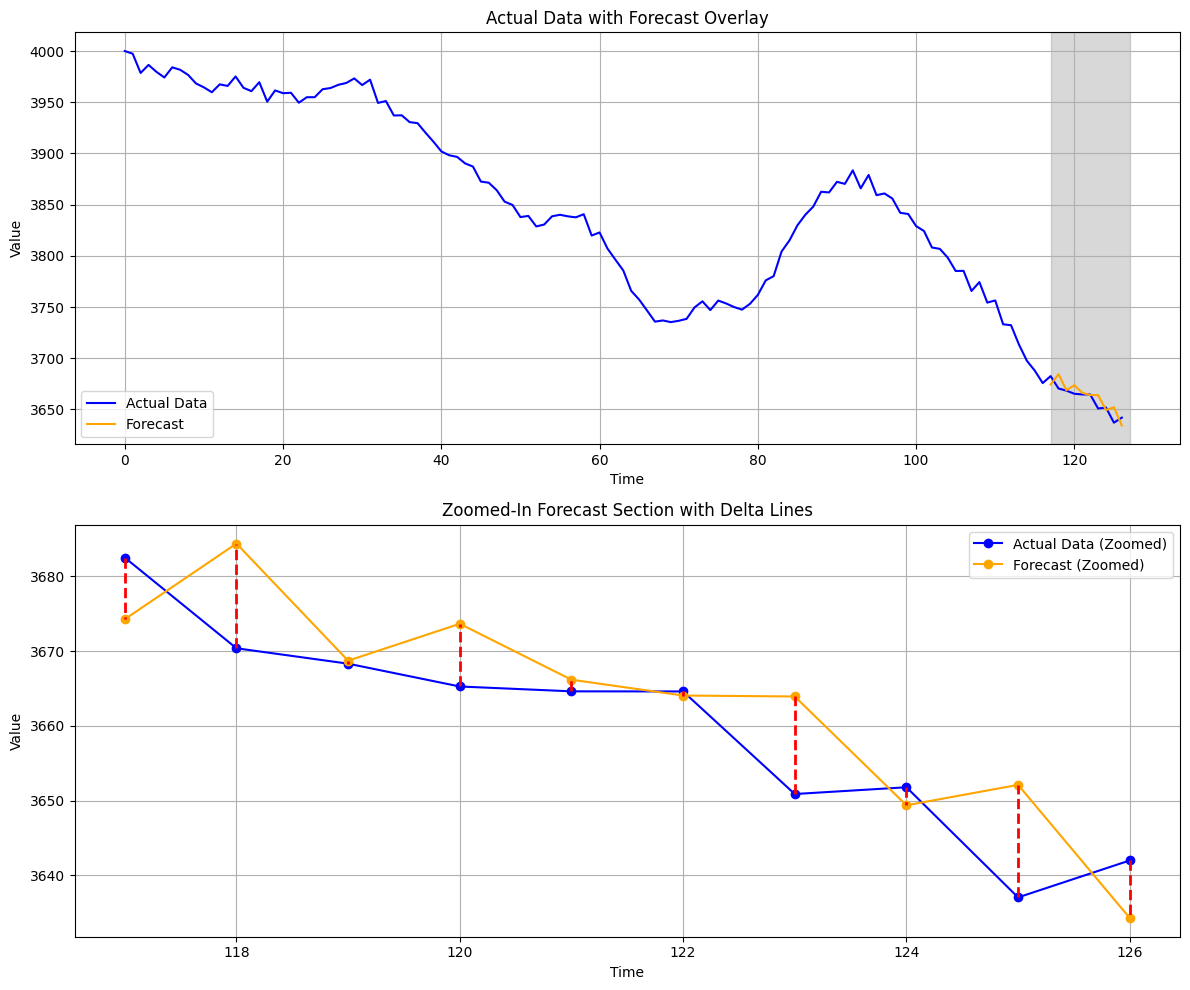

In [125]:
plot_forecast(data['producto1'], forecasts, train_size)